In [1]:
import wandb
import math
import torch
import torchcde
from tqdm import tqdm
import seaborn as sns
import numpy as np 
from matplotlib import pyplot as plt
import os
from pathlib import Path
from scipy.io import loadmat 
import time 
from model import *
from data import *

In [2]:

train_X, train_y, train_time = get_data_seq_raw(fixed = True, t_perturb = True, varying_length= True, rician = True, dataset_size= 100)

100%|██████████| 100/100 [00:00<00:00, 1628.74it/s]


In [3]:
train_X_norm = train_X.clone()
train_y_norm = train_y.clone()
train_time_norm = train_time.clone()
train_X_norm = train_X_norm/torch.Tensor([2000,200])
train_time_norm = train_time_norm/torch.Tensor([2000])
train_y_norm = train_y_norm/torch.Tensor([100,1,1000])



In [6]:
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_X_norm)
train_dataset = torch.utils.data.TensorDataset(train_X_norm, train_coeffs, train_y_norm, train_time_norm)


pseudo code:
    cached results = empty(batchsize)
    for batch in dataloader:
        for i in length(t):


In [9]:
model = NeuralCDE(input_channels=2, hidden_channels=8, output_channels=3)
model.load_state_dict(torch.load('/mnt/vol6t/Projects/NeuralCDE/T1_mapping/scripts/wandb/run-20230612_144916-xdnl6mw4/files/model_at_epoch_6.pt'))

<All keys matched successfully>

In [10]:
model = model.cuda()

In [11]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False)

In [12]:
X.shape

NameError: name 'X' is not defined

In [ ]:
X[:,:2,1] = -X[:,:2,1]

In [ ]:
X

tensor([[[ 0.0239, -1.3191],
         [ 0.0922, -1.1933],
         [ 0.1324,  1.0844],
         [ 0.5112,  0.4763],
         [ 0.6351,  0.2804],
         [ 0.7203,  0.1924],
         [ 1.0017,  0.1236],
         [ 1.1006,  0.1925],
         [ 1.1363,  0.2342],
         [ 1.5196,  0.5163],
         [ 2.0358,  0.8134]],

        [[-0.0137, -1.0142],
         [ 0.0302, -0.8794],
         [ 0.1887,  0.4693],
         [ 0.4940,  0.0409],
         [ 0.5154,  0.0268],
         [ 0.6756,  0.1201],
         [ 1.0396,  0.2776],
         [ 1.0431,  0.2782],
         [ 1.0528,  0.2609],
         [ 1.5592,  0.3425],
         [ 1.9298,  0.3687]],

        [[ 0.0383, -2.3524],
         [ 0.0752, -2.1005],
         [ 0.1081,  1.7724],
         [ 0.4545,  0.3331],
         [ 0.5541,  0.0241],
         [ 0.7234,  0.2425],
         [ 0.9663,  0.5954],
         [ 1.0627,  0.7327],
         [ 1.1259,  0.6884],
         [ 1.5985,  0.9139],
         [ 2.1220,  1.0030]],

        [[ 0.0394, -0.0254],
        

In [151]:
X[0]

tensor([[ 0.0239, -1.3191],
        [ 0.0922, -1.1933],
        [ 0.1324,  1.0844],
        [ 0.5112,  0.4763],
        [ 0.6351,  0.2804],
        [ 0.7203,  0.1924],
        [ 1.0017,  0.1236],
        [ 1.1006,  0.1925],
        [ 1.1363,  0.2342],
        [ 1.5196,  0.5163],
        [ 2.0358,  0.8134]], device='cuda:0')

In [10]:
def curve_loss_val(output, target,time):
    target_signal = torch.abs(target[:,0].unsqueeze(-1)*(1 - target[:,1].unsqueeze(-1)*torch.exp(-1*time.unsqueeze(0)*(target[:,1].unsqueeze(-1) - 1)/target[:,2].unsqueeze(-1))))
    output_signal = torch.abs(output[:,0].unsqueeze(-1)*(1 - output[:,1].unsqueeze(-1)*torch.exp(-1*time.unsqueeze(0)*(output[:,1].unsqueeze(-1) - 1)/output[:,2].unsqueeze(-1))))
    #print(target_signal)
    #print(output_signal)
    loss = torch.abs(target_signal - output_signal)
    #print(loss)
    return loss.mean(axis=1)

In [14]:
for batch in tqdm(train_dataloader):
    X, coeffs, y, t = batch
    X = X.cuda()
    y = y.cuda()
    #print(X)
    print(X.shape[1])
    cached_loss = torch.zeros(X.shape[1], device=X.device)
    cached_results = torch.zeros(X.shape[1], 3, device=X.device)
    for i in range(X.shape[1]):
        X_recover = X.clone()
        X_recover[:,:i,1] = -X[:,:i,1]
        coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_recover)
        current_output = model(coeffs)
        current_loss = curve_loss_val(current_output*(torch.Tensor([100,1,1000]).cuda()), y*(torch.Tensor([100,1,1000]).cuda()), torch.linspace(100,4000,30).cuda())
        print(current_loss[4])
        if i == 0:
            cached_loss = current_loss
            cached_results = current_output
        else:
            cached_results = torch.where((current_loss < cached_loss).reshape(8,1).expand(-1,3), current_output, cached_results)
            cached_loss = torch.where(current_loss < cached_loss, current_loss, cached_loss)
        print(cached_results[4]*torch.Tensor([100,1,1000]).cuda())
    y = y.cuda()
    t = t.cuda()
    break

  0%|          | 0/13 [00:00<?, ?it/s]

11
tensor(65.3052, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 8.4564e+01,  6.0377e-02, -4.0504e+02], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor(763769.3125, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 8.4564e+01,  6.0377e-02, -4.0504e+02], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor(178499.8906, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 8.4564e+01,  6.0377e-02, -4.0504e+02], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor(963.3408, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 8.4564e+01,  6.0377e-02, -4.0504e+02], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor(1993.5012, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 8.4564e+01,  6.0377e-02, -4.0504e+02], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor(1847.7018, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 8.4564e+01,  6.0377e-02, -4.0504e+02], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor(89.9270, device='cuda:0', grad_fn=<Select

  0%|          | 0/13 [00:03<?, ?it/s]

tensor(936.1519, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 8.4564e+01,  6.0377e-02, -4.0504e+02], device='cuda:0',
       grad_fn=<MulBackward0>)


In [15]:
cached_results

tensor([[ 0.1314,  4.2405, -4.9123],
        [-0.3128, -0.6133,  1.3500],
        [ 0.4953,  1.9717, -1.8283],
        [-0.0504, -0.7837,  1.2940],
        [ 0.8456,  0.0604, -0.4050],
        [ 0.5579,  0.0401, -0.1221],
        [-0.2539, -0.6984,  1.3845],
        [ 0.6740,  0.2332, -0.3650]], device='cuda:0',
       grad_fn=<WhereBackward0>)

In [16]:
cached_results.shape

torch.Size([8, 3])

In [17]:
(current_loss < cached_loss).reshape(8,1).expand(-1,3)

tensor([[False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False]], device='cuda:0')

In [18]:
X[4],y[4]*torch.Tensor([100,1,1000]).cuda(),current_output[4]*torch.Tensor([100,1,1000]).cuda()

(tensor([[-0.0107, -1.0937],
         [ 0.0404, -0.9034],
         [ 0.0758, -0.7808],
         [ 0.4506,  0.1109],
         [ 0.6542,  0.4037],
         [ 0.7162,  0.4796],
         [ 0.9931,  0.7265],
         [ 1.0693,  0.7557],
         [ 1.1235,  0.7451],
         [ 1.6126,  0.8847],
         [ 2.0991,  0.9304]], device='cuda:0'),
 tensor([ 201.8022,    2.0727, 1143.9677], device='cuda:0'),
 tensor([-1.3729e+02, -1.1062e+00,  2.9173e+03], device='cuda:0',
        grad_fn=<MulBackward0>))

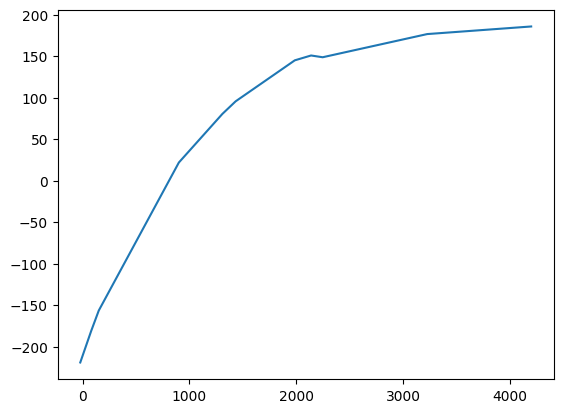

In [19]:
plt.plot((X[4]*torch.Tensor([2000,200]).cuda()).cpu().detach().numpy().reshape(-1,2)[:,0],(X[4]*torch.Tensor([2000,200]).cuda()).cpu().detach().numpy().reshape(-1,2)[:,1])

In [20]:
current_loss.mean(axis=1)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

# Try MLP

In [4]:
def curve_loss_val(output, target,inv_times):
    target_signal = target[:,0].unsqueeze(-1)*(1 - target[:,1].unsqueeze(-1)*torch.exp(-1*inv_times.unsqueeze(0)/target[:,2].unsqueeze(-1)))
    output_signal = output[:,0].unsqueeze(-1)*(1 - output[:,1].unsqueeze(-1)*torch.exp(-1*inv_times.unsqueeze(0)/output[:,2].unsqueeze(-1)))
    #print(target_signal)
    #print(output_signal)
    loss = torch.abs(target_signal - output_signal)
    #print(loss)
    return loss.mean(axis=1)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Set the seaborn theme
sns.set_theme()

In [66]:
model = MLP_myomapnet(input_channels=22, hidden_channels=400, output_channels=3)
model.load_state_dict(torch.load('/mnt/vol6t/Projects/NeuralCDE/T1_mapping/scripts/wandb/run-20230613_175241-jl7j9ile/files/model_at_epoch_31.pt'))
model = model.cuda()

In [67]:

train_X, train_y, train_time = get_data_seq_raw(fixed = True, t_perturb = True, varying_length= False, rician = False, dataset_size= 100)
train_X_norm = train_X.clone()
train_y_norm = train_y.clone()
train_time_norm = train_time.clone()
train_X_norm = train_X_norm/torch.Tensor([2000,200])
train_time_norm = train_time_norm/torch.Tensor([2000])
train_y_norm = train_y_norm/torch.Tensor([100,1,1000])



train_X_norm = (train_X_norm).reshape([-1,22])
print(train_X_norm[0])
train_dataset = torch.utils.data.TensorDataset(train_X_norm, train_y_norm)


100%|██████████| 100/100 [00:00<00:00, 5725.15it/s]

tensor([-0.0197, -0.4481,  0.1712, -0.3698,  0.2149, -0.2938,  0.5280,  0.0917,
         0.5912,  0.1403,  0.6981,  0.1988,  0.9234,  0.3661,  0.9959,  0.3839,
         1.0499,  0.4190,  1.5495,  0.5470,  2.0314,  0.6038])


In [61]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False)

In [68]:
index = 5
predicted_parameters = []
for batch in tqdm(train_dataloader):
    batch_coeffs, batch_y= batch
    batch_coeffs = batch_coeffs.cuda()
    batch_y = batch_y.cuda()
    cached_loss = torch.zeros(batch_coeffs.shape[1], device=batch_coeffs.device)
    cached_results = torch.zeros(batch_coeffs.shape[1], 3, device=batch_coeffs.device)
    for i in range(batch_coeffs.shape[1]//2):
        print(f'current invert point is {i+1}')
        coeffs_recover = batch_coeffs.clone()
        #coeffs_recover[:,1:i*2+2:2] = -batch_coeffs[:,1:i*2+2:2]
        print(coeffs_recover[index])
        current_output = model(coeffs_recover)
        predicted_parameters.append(current_output[index]*torch.Tensor([100,1,1000]).cuda())
        current_loss = curve_loss_val(current_output*(torch.Tensor([100,1,1000]).cuda()), batch_y*(torch.Tensor([100,1,1000]).cuda()), torch.linspace(100,4000,30).cuda())
        print(current_output[index]*torch.Tensor([100,1,1000]).cuda())
        print(current_loss[index])
        if i == 0:
            cached_loss = current_loss
            cached_results = current_output
        else:
            cached_results = torch.where((current_loss < cached_loss).reshape(batch_coeffs.shape[0],1).expand(-1,3), current_output, cached_results)
            cached_loss = torch.where(current_loss < cached_loss, current_loss, cached_loss)
        #print(cached_results[4]*torch.Tensor([100,1,1000]).cuda())
        print(batch_y[index] * torch.Tensor([100, 1, 1000]).cuda())
        print(cached_loss[index])
    break

print(cached_results[index]*torch.Tensor([100,1,1000]).cuda())

  0%|          | 0/13 [00:00<?, ?it/s]

current invert point is 1
tensor([ 0.1382, -1.3180,  0.1666, -1.2318,  0.1877, -1.0952,  0.5415, -0.6318,
         0.5766, -0.5299,  0.5915, -0.4427,  0.9734, -0.1631,  1.1180, -0.1350,
         1.1299, -0.0466,  1.5460,  0.2600,  1.9497,  0.3902], device='cuda:0')
tensor([ 361.4833,    0.0000, 2468.5039], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor(411.7608, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 155.4302,    2.8460, 2302.5959], device='cuda:0')
tensor(411.7608, device='cuda:0', grad_fn=<SelectBackward0>)
current invert point is 2
tensor([ 0.1382, -1.3180,  0.1666, -1.2318,  0.1877, -1.0952,  0.5415, -0.6318,
         0.5766, -0.5299,  0.5915, -0.4427,  0.9734, -0.1631,  1.1180, -0.1350,
         1.1299, -0.0466,  1.5460,  0.2600,  1.9497,  0.3902], device='cuda:0')
tensor([ 361.4833,    0.0000, 2468.5039], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor(411.7608, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 155.4302,    2.8460, 2302.5959], devi

In [69]:
ground_truth = (batch_y[index]*torch.Tensor([100,1,1000]).cuda()).cpu().detach().numpy()

In [70]:
def T1_3param(t, C, k, T1):
    '''
    MOLLI signal acquistion equation s(t) = C(1 - k * np.exp(-t*(k-1)/T1))
    '''
    return C*(1 - k * np.exp(-t*(k-1)/T1))

def T1_3param_modified(t, C, k, T1_star):
    '''
    MOLLI signal acquistion equation s(t) = C(1 - k * np.exp(-t/T1_star))
    '''
    return C*(1 - k * np.exp((-t)/T1_star))

In [33]:
ground_truth = (current_output[0]*torch.Tensor([100,1,10]).cuda()).cpu().detach().numpy()

Fitted[ 361.48328    0.      2468.504  ]
Ground Truth[ 155.43022      2.8459744 2302.596    ]


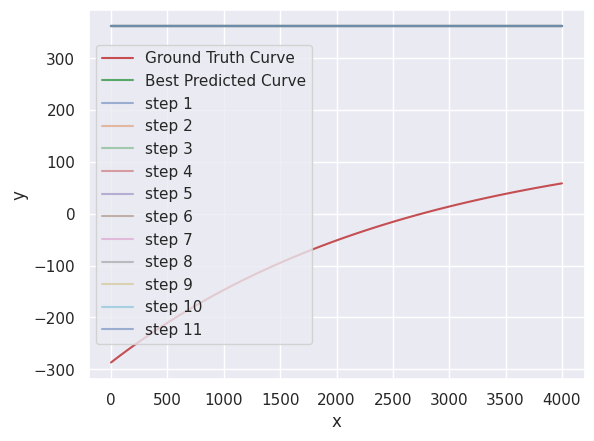

In [71]:
y_fit = T1_3param_modified(np.linspace(0,3500,100), ground_truth[0], ground_truth[1], ground_truth[2])
cached_results_recovered = cached_results[index]*torch.Tensor([100,1,1000]).cuda()
y_predict = T1_3param_modified(np.linspace(0,3500,100), cached_results_recovered[0].cpu().detach().numpy(), cached_results_recovered[1].cpu().detach().numpy(), cached_results_recovered[2].cpu().detach().numpy())
print(f"Fitted{(cached_results[index]*torch.Tensor([100,1,1000]).cuda()).cpu().detach().numpy()}")
print(f"Ground Truth{(batch_y[index]*torch.Tensor([100,1,1000]).cuda()).cpu().detach().numpy()}")
#print("ground truth"+(batch_y[4]*torch.Tensor([100,1,1000]).cuda()).cpu().detach().numpy())
time_tensor = torch.linspace(100,4000,30)
x = np.linspace(0,3500,100)
# Plot the original data and the fitted curve
#plt.plot(x, y, 'bo', label='Original Data')
plt.plot(np.linspace(0,time_tensor.max(),100), y_fit, 'r-', label='Ground Truth Curve')
plt.plot(np.linspace(0,time_tensor.max(),100), y_predict, 'g-', label='Best Predicted Curve')

for i in range(len(predicted_parameters)):
    y_pred = predicted_parameters[i]
    y_pred = T1_3param_modified(np.linspace(0,3500,100), y_pred[0].cpu().detach().numpy(), y_pred[1].cpu().detach().numpy(), y_pred[2].cpu().detach().numpy())
    plt.plot(np.linspace(0,time_tensor.max(),100), y_pred,  label = str(f'step {(i+1)}'),alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [57]:
predicted_parameters

[tensor([ 320.0849,    0.0000, 1391.0880], device='cuda:0',
        grad_fn=<MulBackward0>),
 tensor([ 320.0849,    0.0000, 1391.0880], device='cuda:0',
        grad_fn=<MulBackward0>),
 tensor([ 320.0849,    0.0000, 1391.0880], device='cuda:0',
        grad_fn=<MulBackward0>),
 tensor([ 320.0849,    0.0000, 1391.0880], device='cuda:0',
        grad_fn=<MulBackward0>),
 tensor([ 320.0849,    0.0000, 1391.0880], device='cuda:0',
        grad_fn=<MulBackward0>),
 tensor([ 320.0849,    0.0000, 1391.0880], device='cuda:0',
        grad_fn=<MulBackward0>),
 tensor([ 320.0849,    0.0000, 1391.0880], device='cuda:0',
        grad_fn=<MulBackward0>),
 tensor([ 320.0849,    0.0000, 1391.0880], device='cuda:0',
        grad_fn=<MulBackward0>),
 tensor([ 320.0849,    0.0000, 1391.0880], device='cuda:0',
        grad_fn=<MulBackward0>),
 tensor([ 320.0849,    0.0000, 1391.0880], device='cuda:0',
        grad_fn=<MulBackward0>),
 tensor([ 320.0849,    0.0000, 1391.0880], device='cuda:0',
        gr

In [22]:
def curve_loss(output, target,inv_times):
    target_signal = target[:,0].unsqueeze(-1)*(1 - target[:,1].unsqueeze(-1)*torch.exp(-1*inv_times.unsqueeze(0)*(target[:,1].unsqueeze(-1) - 1)/target[:,2].unsqueeze(-1)))
    output_signal = output[:,0].unsqueeze(-1)*(1 - output[:,1].unsqueeze(-1)*torch.exp(-1*inv_times.unsqueeze(0)*(output[:,1].unsqueeze(-1) - 1)/output[:,2].unsqueeze(-1)))
    print(target_signal)
    print(output_signal)
    loss = torch.mean(torch.abs(target_signal - output_signal))
    #print(loss)
    return loss


In [72]:
a = torch.Tensor([1,2,3,4,5,6,7,8,9,10])
b = torch.Tensor([1,2,3,4,5,6,7,8,9,10])
a*(b-1)

tensor([ 0.,  2.,  6., 12., 20., 30., 42., 56., 72., 90.])

In [243]:
current_output[0]*torch.Tensor([100,0.01,10]).cuda()

tensor([4.6488e+02, 3.4988e-02, 1.6109e+01], device='cuda:0',
       grad_fn=<MulBackward0>)

In [241]:
curve_loss(current_output*(torch.Tensor([100,0.01,10]).cuda()), batch_y*(torch.Tensor([100,0.01,10]).cuda()), torch.linspace(100,4000,30).cuda())

tensor([[-2.2432e+04, -4.2011e+08, -7.7047e+12, -1.4130e+17, -2.5914e+21,
         -4.7525e+25, -8.7158e+29, -1.5984e+34, -2.9314e+38,        -inf,
                -inf,        -inf,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf,        -inf,        -inf],
        [-1.6300e+03, -3.3152e+06, -5.3683e+09, -8.6920e+12, -1.4073e+16,
         -2.2787e+19, -3.6895e+22, -5.9737e+25, -9.6722e+28, -1.5661e+32,
         -2.5357e+35,        -inf,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf,        -inf,        -inf],
        [-1.7107e+02, -3.7468e+05, -5.0351e+08, -6.7643e+11, -9.0876e+14,
         -1.2209e+18, -1.6402e+21, -

tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)

In [254]:
batch_y[:,2]*batch_y[:,1]

tensor([4.3163, 3.5911, 2.2502, 2.4223, 2.6543, 2.2325, 5.4543, 2.4027],
       device='cuda:0')